In [1]:
!pip install pytorch_lightning
!pip install pytorch_forecasting==0.8.2
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
import datetime
import os
import warnings
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
warnings.filterwarnings("ignore")
pl.seed_everything(666)
from google.colab import drive
drive.mount('/content/drive')
path = os.getcwd()+f'/drive/MyDrive/Machine learning/wow'


     |████████████████████████████████| 686kB 9.1MB/s 
     |████████████████████████████████| 829kB 11.3MB/s 
     |████████████████████████████████| 276kB 35.0MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 1.3MB 35.8MB/s 
     |████████████████████████████████| 143kB 60.5MB/s 
     |████████████████████████████████| 296kB 53.5MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=4583fcd3b5389d2b8cc4651440231aa14587b0e24811b1330a18bbbc9fa4a46e
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=70a5ea159a6e597ad8323096c3a086aef954a563b0f5ff56ef9678e5af26c756
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163

Global seed set to 666


Mounted at /content/drive


In [2]:
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/Machine learning/wow'

In [3]:
pl.seed_everything(666)

Global seed set to 666


666

In [4]:
df_small = pd.read_csv('Token-prices-small2021-01-15.csv')
df_day = pd.read_csv('Token-prices-day2021-01-15.csv')
df_day.price=df_day.price.astype('float')
df_small.price=df_small.price.astype('float')

# TimeSeriesDataSets 

In [5]:
def between_week(date,dates):
  date=pd.to_datetime(date)
  for start_date in dates:
    start_date = pd.to_datetime(start_date)
    week = datetime.timedelta(weeks=1)
    end_date = pd.to_datetime(start_date)+week
    if date >= pd.to_datetime(start_date) and date <= end_date:
      return 1 
  return 0

In [6]:
expansion_realise_dates=['2014-11-13','2016-08-30','2018-08-13','2020-08-26']

## Small timeperiod dataset

In [7]:
data=pd.DataFrame.copy(df_small)
data

,price,time,date,day_of_week,hour,day,month,7_day_std,30_day_std,7_day_mean,30_day_mean,1_day_mean,7_day_low,30_day_low,7_day_high,30_day_high,1_day_high,1_day_low,last_change
0,35704.0,1429648533,2015-04-21 22:35:33,1,22,21,4,352.001894,352.001894,35351.333333,35351.333333,35351.333333,35000.0,35000.0,35704.0,35704.0,35704.0,35000.0,704.0
1,36061.0,1429649396,2015-04-21 22:49:56,1,22,21,4,456.629226,456.629226,35528.750000,35528.750000,35528.750000,35000.0,35000.0,36061.0,36061.0,36061.0,35000.0,711.0
2,36422.0,1429650302,2015-04-21 23:05:02,1,23,21,4,562.104795,562.104795,35707.400000,35707.400000,35707.400000,35000.0,35000.0,36422.0,36422.0,36422.0,35000.0,718.0
3,36786.0,1429651238,2015-04-21 23:20:38,1,23,21,4,668.330582,668.330582,35887.166667,35887.166667,35887.166667,35000.0,35000.0,36786.0,36786.0,36786.0,35000.0,725.0
4,37154.0,1429652111,2015-04-21 23:35:11,1,23,21,4,775.556666,775.556666,36068.142857,36068.142857,36068.142857,35000.0,35000.0,37154.0,37154.0,37154.0,35000.0,732.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133452,160569.0,1610720603,2021-01-15 15:23:23,4,15,15,1,3050.854271,2887.161845,160933.333333,160442.181572,160505.222222,155955.0,155921.0,173013.0,173013.0,163376.0,158573.0,1826.0
133453,161550.0,1610721803,2021-01-15 15:43:23,4,15,15,1,3047.524487,2887.025150,160941.005952,160444.489612,160546.569444,155955.0,155921.0,173013.0,173013.0,163376.0,158670.0,1943.0
133454,162004.0,1610723003,2021-01-15 16:03:23,4,16,15,1,3043.972858,2887.206252,160949.980159,160446.915989,160585.583333,155955.0,155921.0,173013.0,173013.0,163376.0,158670.0,1435.0
133455,162092.0,1610724203,2021-01-15 16:23:23,4,16,15,1,3040.749865,2887.539462,160958.865079,160449.085818,160614.041667,155955.0,155921.0,173013.0,173013.0,163376.0,158670.0,542.0


In [24]:
data['expansion_week']=data.date.apply(lambda x: between_week(x,expansion_realise_dates))
data['time_idx']=data.index
data['series']=0
day=3*24
max_prediction_length = day*7
max_encoder_length = 10*day
training_cutoff = data["time_idx"].max() - max_prediction_length
context_length = max_encoder_length
prediction_length = max_prediction_length
data.day_of_week=data.day_of_week.astype('category')
data.hour=data.hour.astype('category').apply(str)
data.series=data.series.astype('category').apply(str)
data.day_of_week=data.day_of_week.astype('category').apply(str)
data.month=data.month.astype('category').apply(str)
data.expansion_week=data.expansion_week.astype('category').apply(str)
date_realated= ["day_of_week", "hour","expansion_week",'month']
list(data.columns)

AttributeError: ignored

In [ ]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="price",
    group_ids=["series"],
    time_varying_unknown_reals=["price",'last_change'],
    time_varying_known_reals=["time_idx"],
    time_varying_known_categoricals=date_realated,
    min_encoder_length=context_length,
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    min_prediction_length=prediction_length,
    target_normalizer=GroupNormalizer(groups=["series"], transformation="softplus"),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

Dataloadery dla treningu i walidacji

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff)
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

# Baseline model

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
base_model = Baseline()
raw_predictions, x = base_model.predict(val_dataloader, mode="raw", return_x=True)
base_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

In [ ]:
predictions = base_model.predict(val_dataloader)
print('MAE',(actuals - predictions).abs().mean())
print('SMAPE',SMAPE()(predictions, actuals))

# TFT - dla małych serii

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 325   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedRe

Restored states from the checkpoint file at /content/drive/My Drive/Machine learning/wow/lr_find_temp_model.ckpt

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 325   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedRes

suggested learning rate: 0.05011872336272722


1

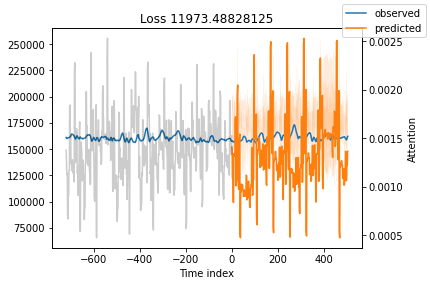

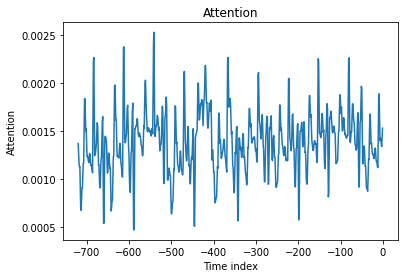

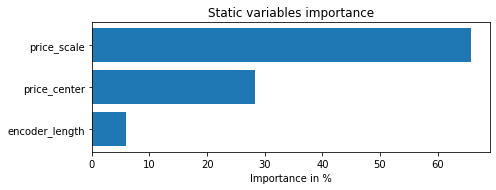

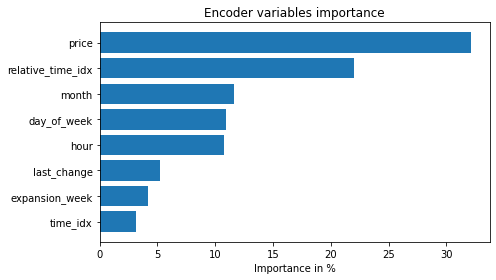

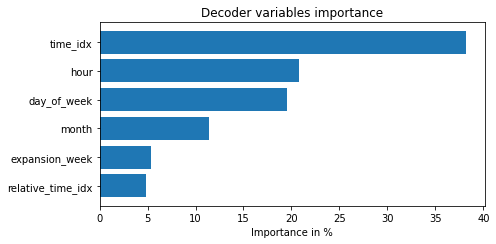

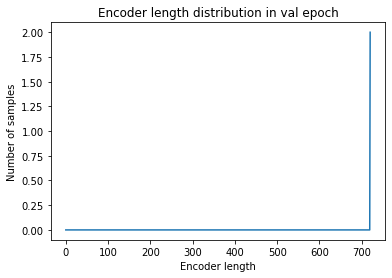

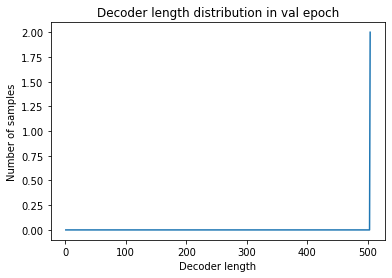

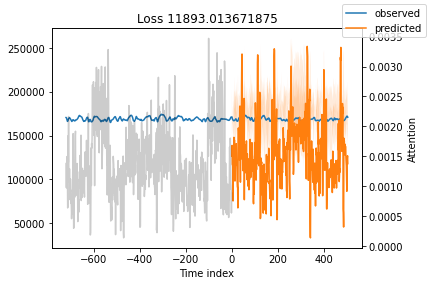

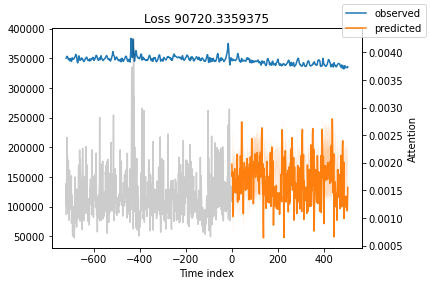

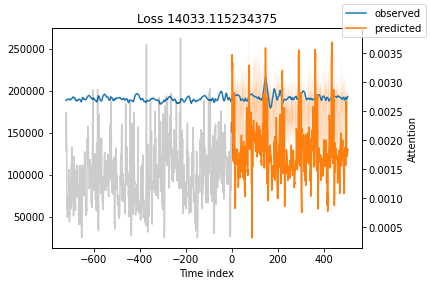

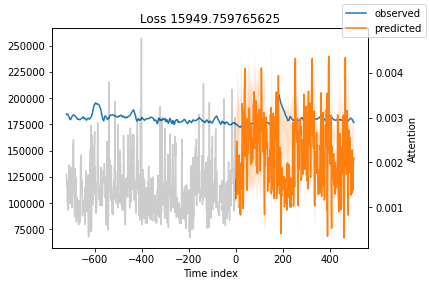

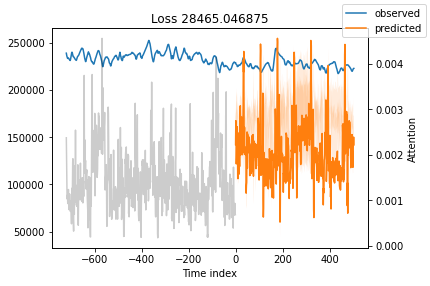

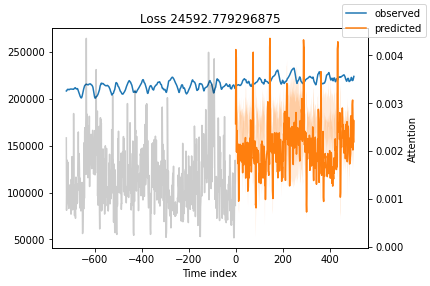

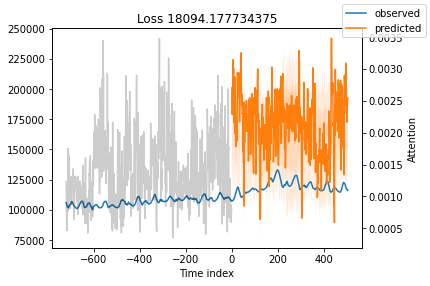

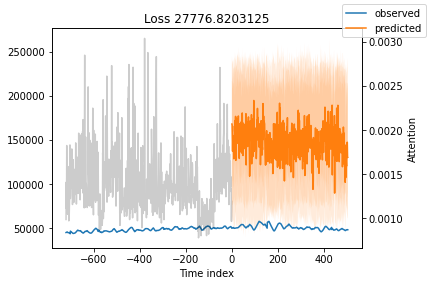

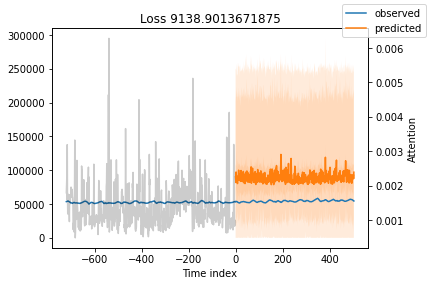

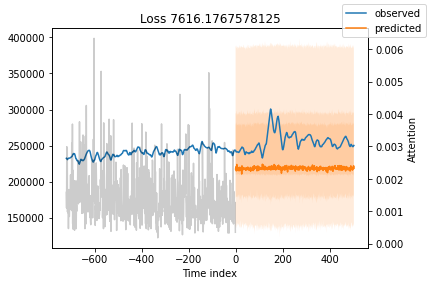

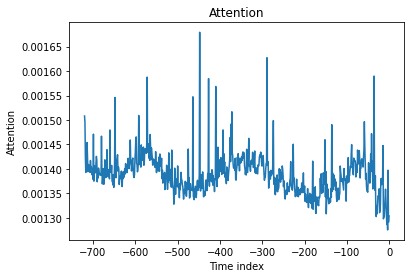

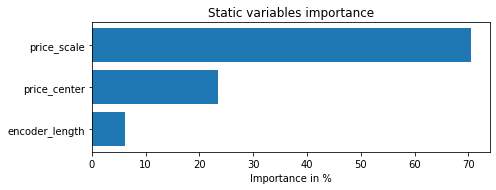

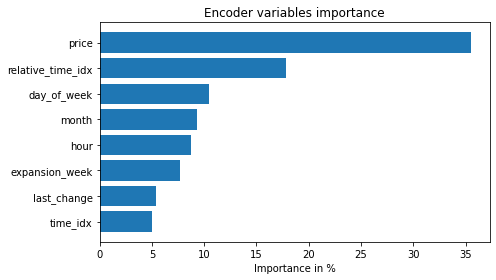

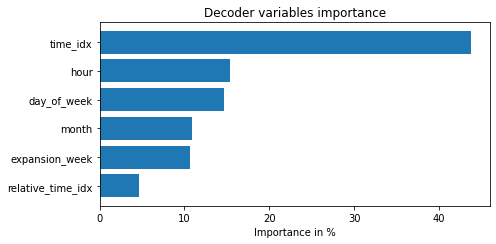

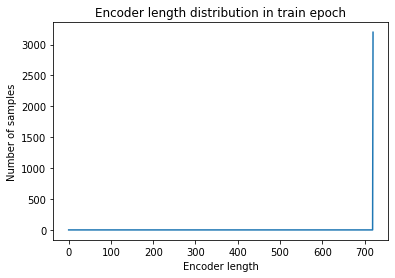

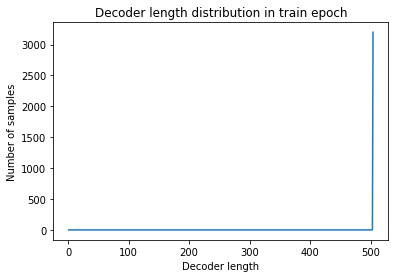

In [13]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    limit_train_batches=300,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

res = trainer.tuner.lr_find(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
tft.hparams.learning_rate = res.suggestion()
print(f"suggested learning rate: {res.suggestion()}")
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [14]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
print('MAE',(actuals - predictions).abs().mean())
print('SMAPE',SMAPE()(predictions, actuals))

MAE tensor(10209.8379)
SMAPE tensor(0.0653)


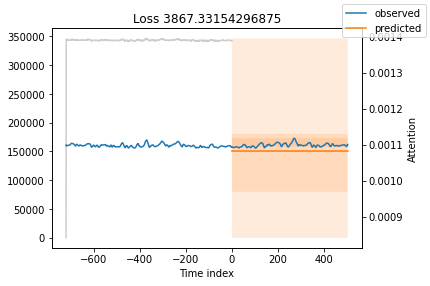

In [15]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

# TFT dla średnich z dnia

In [16]:
data=pd.DataFrame.copy(df_day)
data

,price,day_of_week,day,month,last_change,7_day_low,30_day_low,7_day_high,30_day_high,7_day_mean,30_day_mean,date
0,34058.500000,3.0,23.0,4.0,-2191.875000,34058.500000,34058.500000,41571.255319,41571.255319,37293.376773,37293.376773,2015-04-23
1,37422.458333,4.0,24.0,4.0,-4148.796986,34058.500000,34058.500000,41571.255319,41571.255319,37325.647163,37325.647163,2015-04-24
2,34447.492537,5.0,25.0,4.0,388.992537,34058.500000,34058.500000,41571.255319,41571.255319,36750.016238,36750.016238,2015-04-25
3,38888.300000,6.0,26.0,4.0,1465.841667,34058.500000,34058.500000,41571.255319,41571.255319,37106.396865,37106.396865,2015-04-26
4,39143.232877,0.0,27.0,4.0,4695.740339,34058.500000,34058.500000,41571.255319,41571.255319,37397.373438,37397.373438,2015-04-27
...,...,...,...,...,...,...,...,...,...,...,...,...
2043,162693.583333,0.0,11.0,1.0,4157.791667,158357.194444,158357.194444,162693.583333,162990.277778,159906.607794,160433.187024,2021-01-11
2044,163558.319444,1.0,12.0,1.0,3112.541667,158357.194444,158357.194444,163558.319444,163558.319444,160095.264540,160571.940496,2021-01-12
2045,161020.366197,2.0,13.0,1.0,-1673.217136,158357.194444,158357.194444,163558.319444,163558.319444,160449.582160,160448.821022,2021-01-13
2046,160985.666667,3.0,14.0,1.0,-2572.652778,158535.791667,158357.194444,163558.319444,163558.319444,160825.078191,160420.176925,2021-01-14


In [17]:
data['expansion_week']=data.date.apply(lambda x: between_week(x,expansion_realise_dates))
data['time_idx']=data.index
data['series']=0
day=1
max_prediction_length = day*7
max_encoder_length = 10*day
training_cutoff = data["time_idx"].max() - max_prediction_length
context_length = max_encoder_length
prediction_length = max_prediction_length
data.day_of_week=data.day_of_week.astype('category')
data.series=data.series.astype('category').apply(str)
data.day_of_week=data.day_of_week.astype('category').apply(str)
data.month=data.month.astype('category').apply(str)
data.expansion_week=data.expansion_week.astype('category').apply(str)
date_realated= ["day_of_week","expansion_week",'month']
list(data.columns)

['price',
 'day_of_week',
 'day',
 'month',
 'last_change',
 '7_day_low',
 '30_day_low',
 '7_day_high',
 '30_day_high',
 '7_day_mean',
 '30_day_mean',
 'date',
 'expansion_week',
 'time_idx',
 'series']

In [18]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="price",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["price",'last_change'],
    time_varying_known_reals=["time_idx"],
    time_varying_known_categoricals=date_realated,
    min_encoder_length=context_length,
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    min_prediction_length=prediction_length,
    target_normalizer=GroupNormalizer(groups=["series"], transformation="softplus"),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [19]:
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff)
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

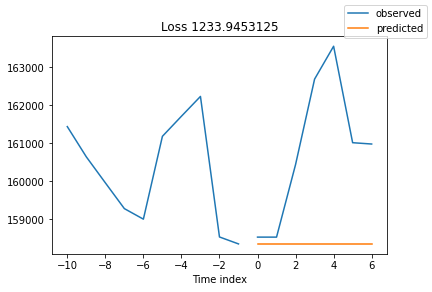

In [20]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
base_model = Baseline()
raw_predictions, x = base_model.predict(val_dataloader, mode="raw", return_x=True)
base_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 109   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedRe

Restored states from the checkpoint file at /content/drive/My Drive/Machine learning/wow/lr_find_temp_model.ckpt

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 109   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedRes

suggested learning rate: 0.07943282347242817


1

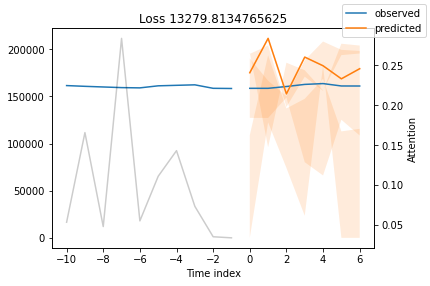

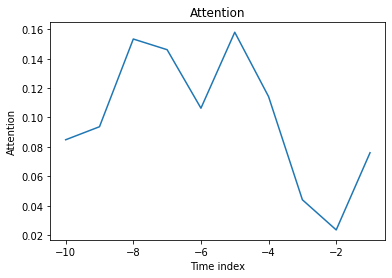

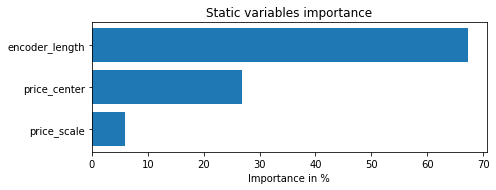

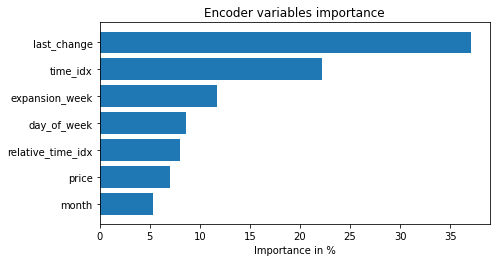

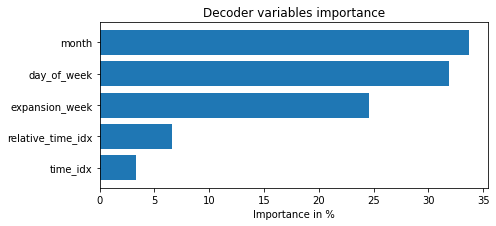

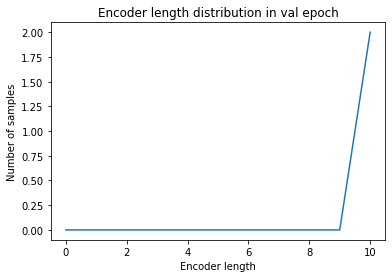

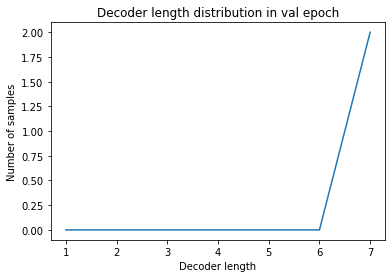

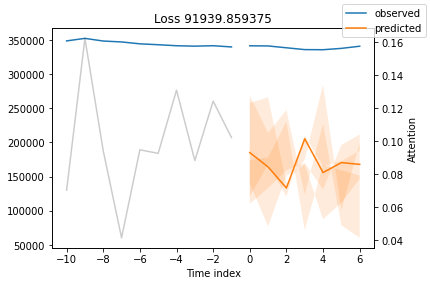

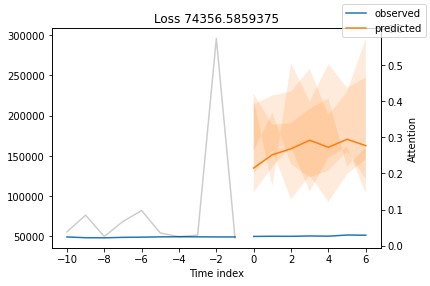

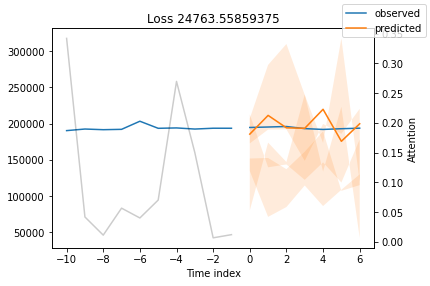

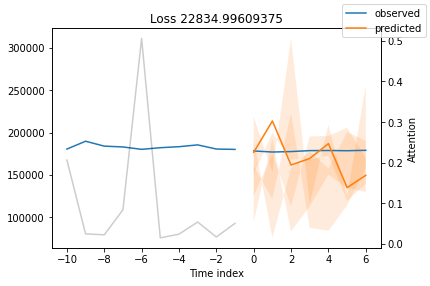

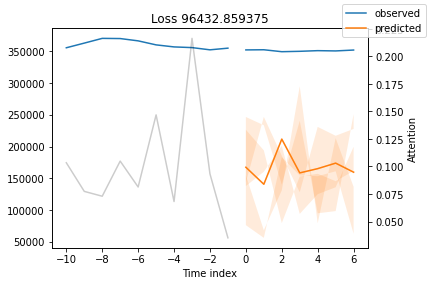

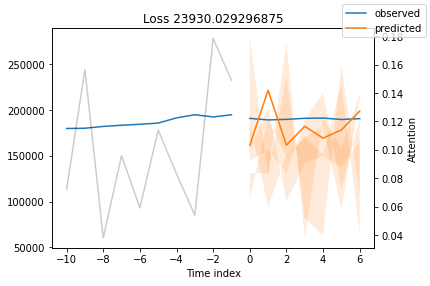

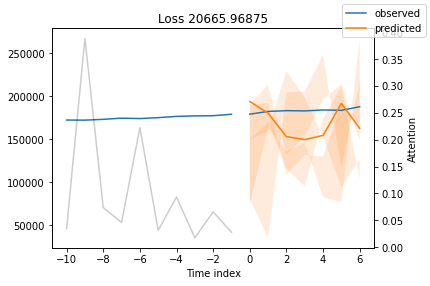

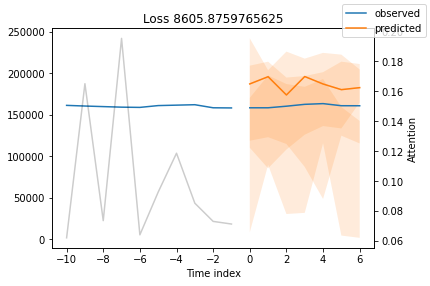

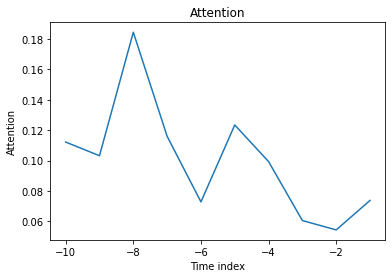

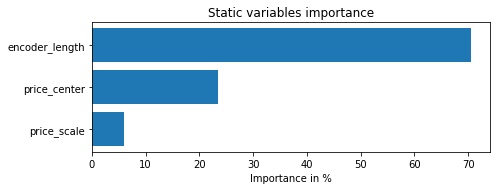

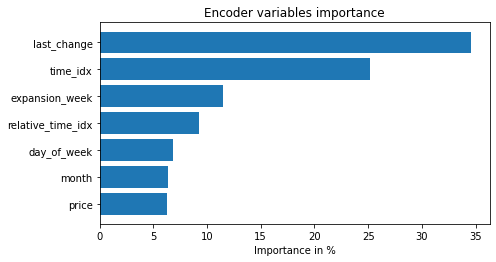

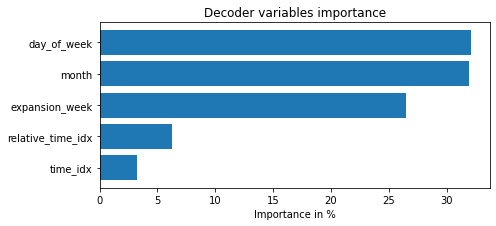

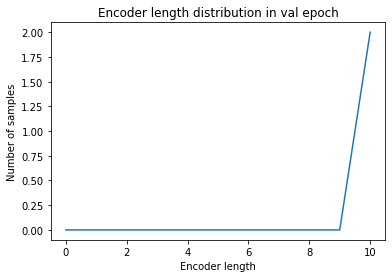

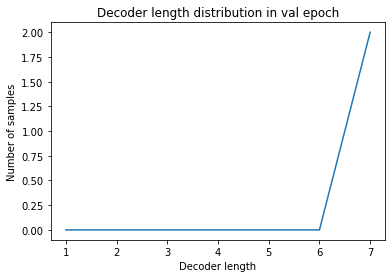

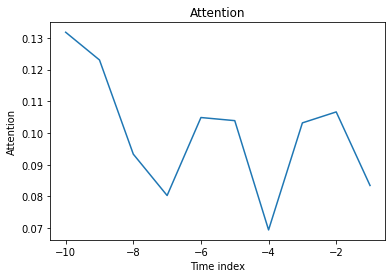

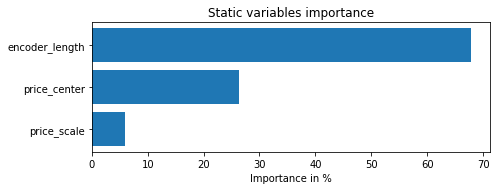

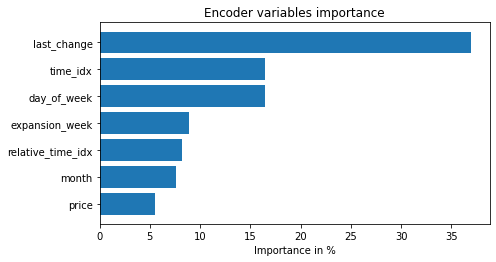

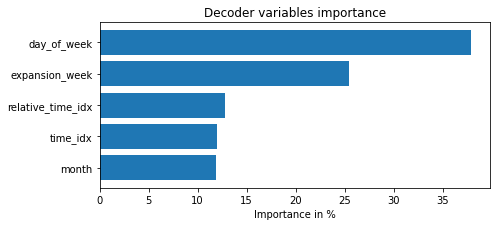

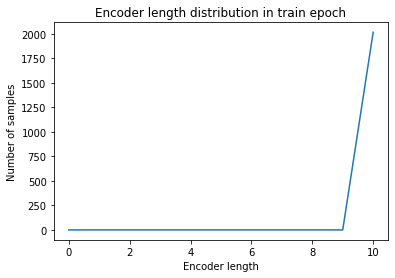

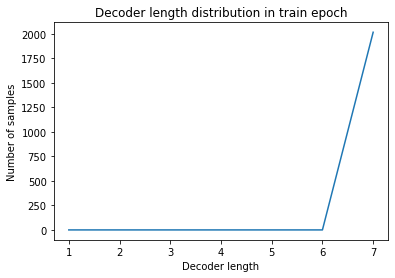

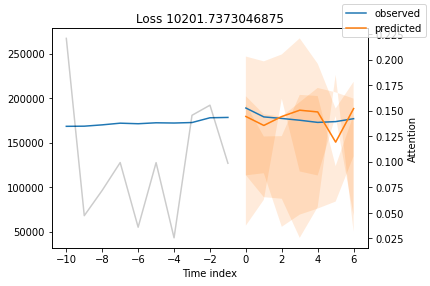

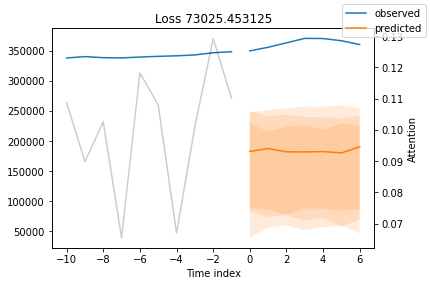

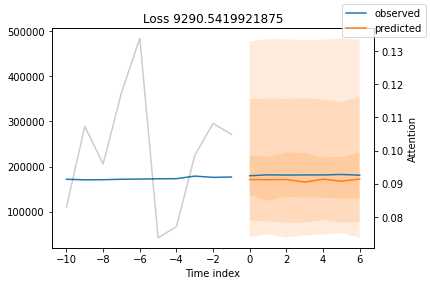

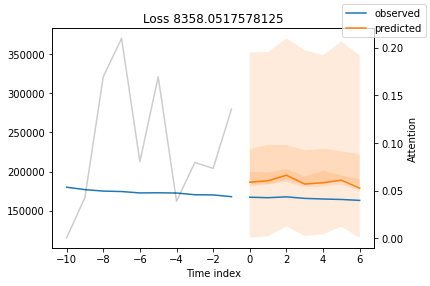

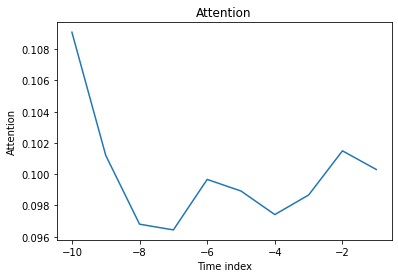

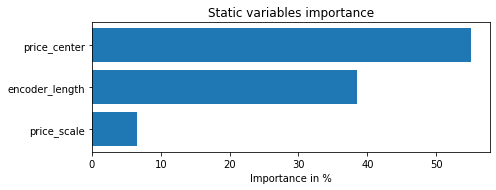

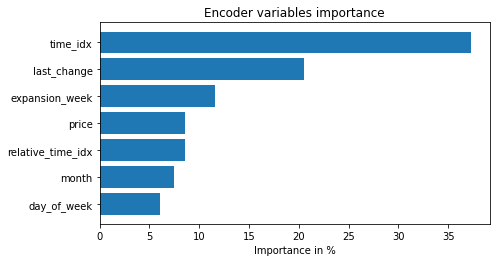

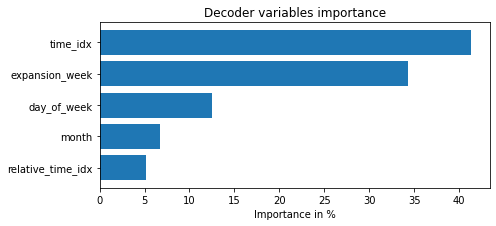

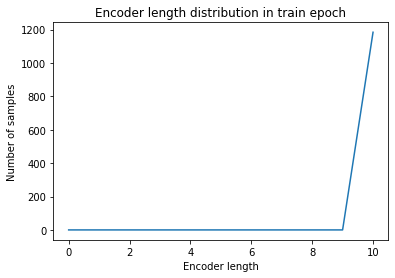

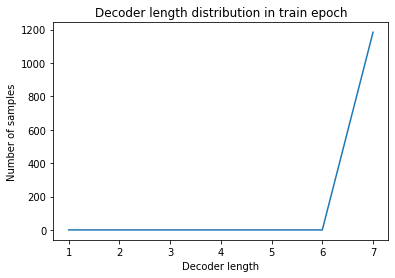

In [21]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    limit_train_batches=300,
)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7, 
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

res = trainer.tuner.lr_find(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
tft.hparams.learning_rate = res.suggestion()
print(f"suggested learning rate: {res.suggestion()}")
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [22]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
print('MAE',(actuals - predictions).abs().mean())
print('SMAPE',SMAPE()(predictions, actuals))

MAE tensor(8841.4277)
SMAPE tensor(0.0535)


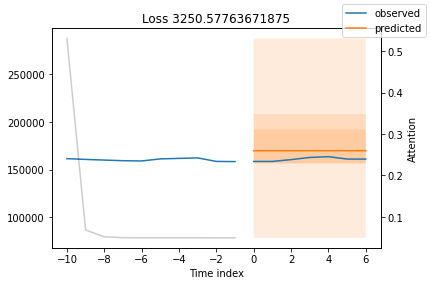

In [23]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);